<a href="https://colab.research.google.com/github/Qukoyk/oddball/blob/master/%E5%AE%9F%E9%A8%93A_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
分析したいチャンネルの番号を入力ください：
1

チャンネルデータ読み込み中……
読み込み完成

フィルターリング開始
フィルターリング済み

トリガー抽出開始……

全トリガーが 60 個検出された

これからトリガー前後の波形を表示
1


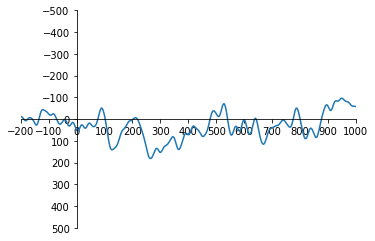

2


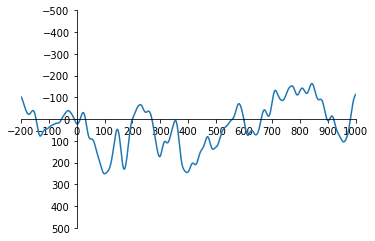

3


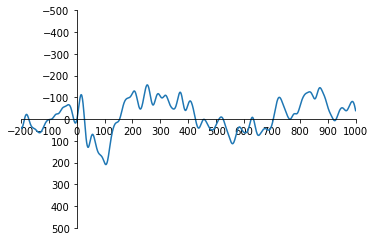

4


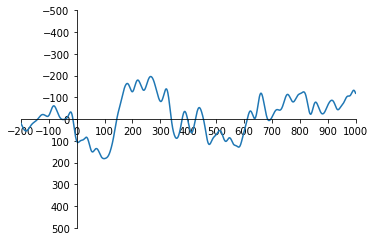

5


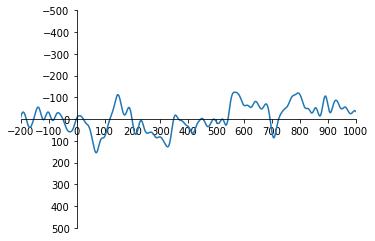

6


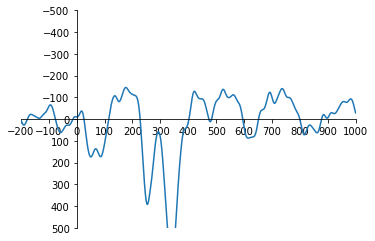

7


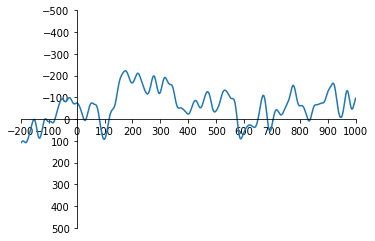

8


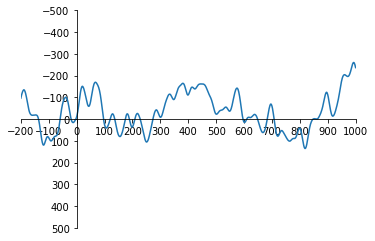

9


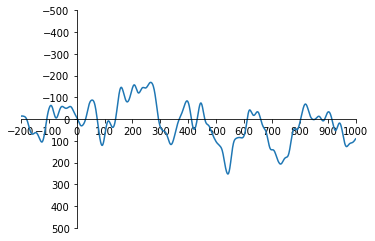

10


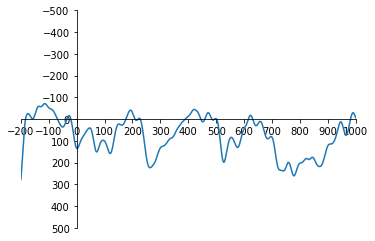

11


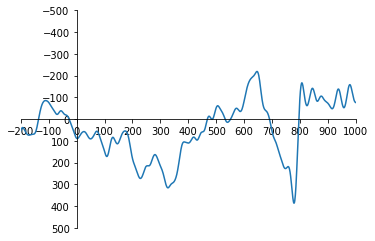

12


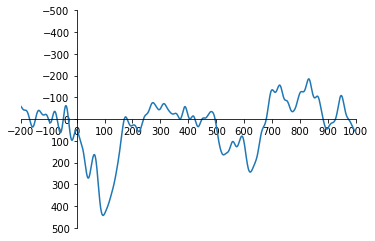

13


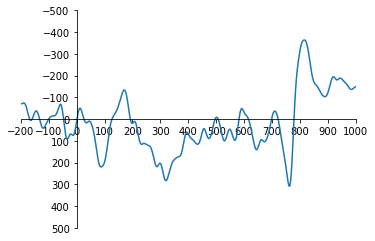

14


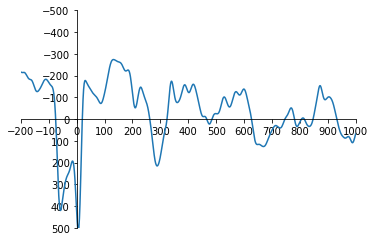

15


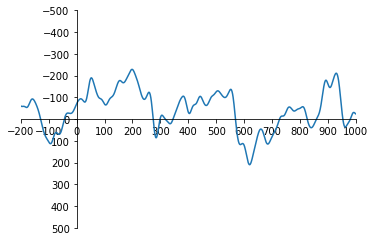

16


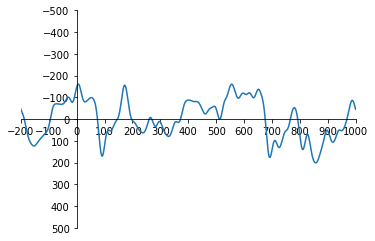

17


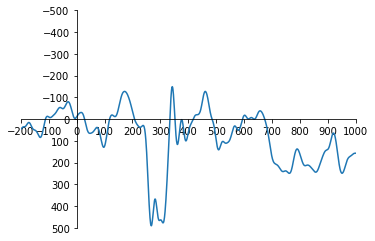

18


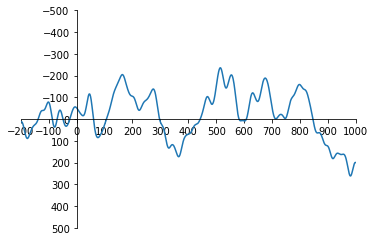

19


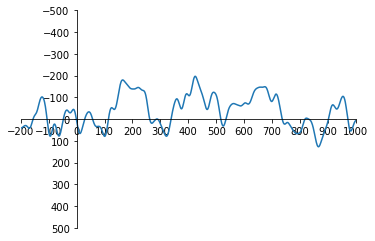

20


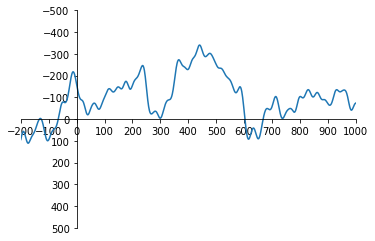

21


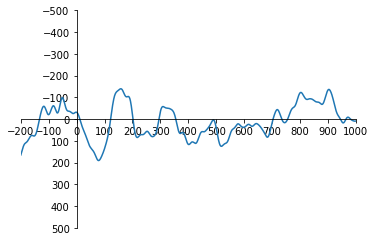

22


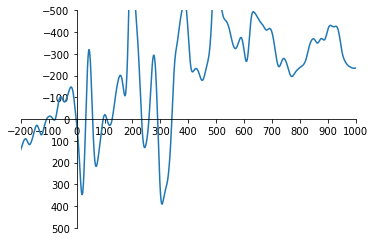

23


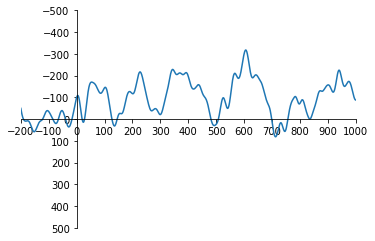

24


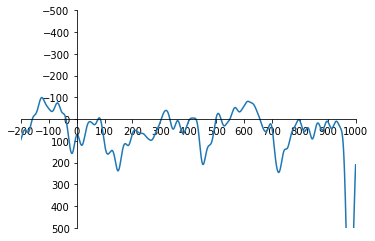

25


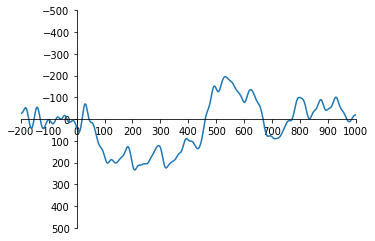

26


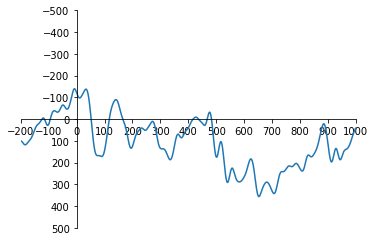

27


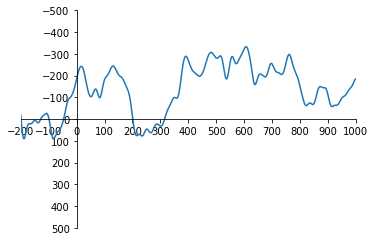

28


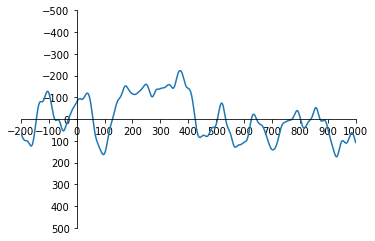

29


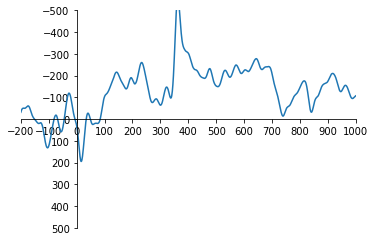

30


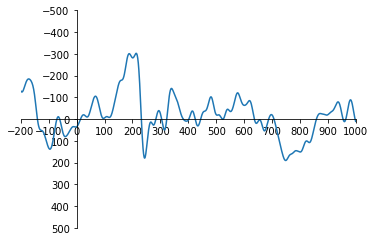

31


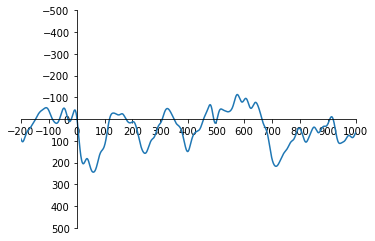

32


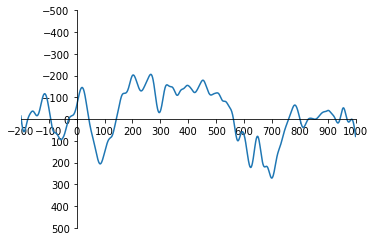

33


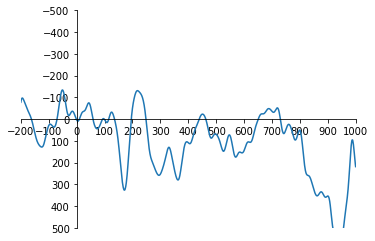

34


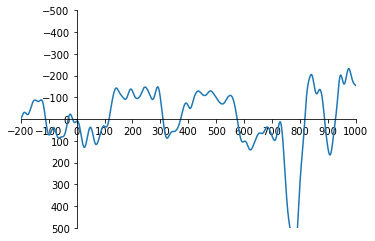

35


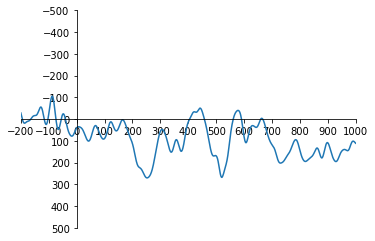

36


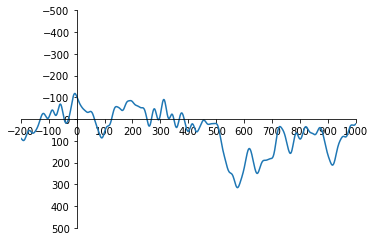

37


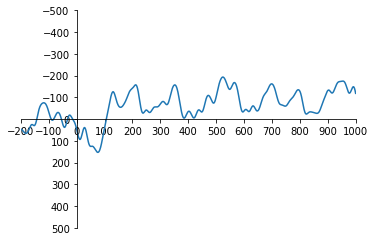

38


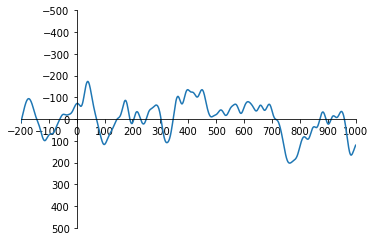

39


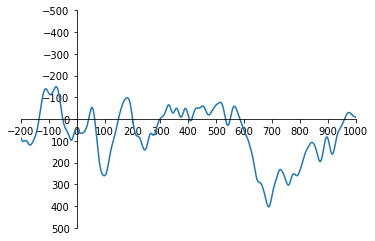

40


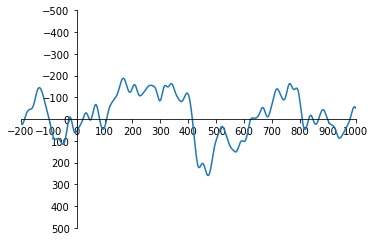

41


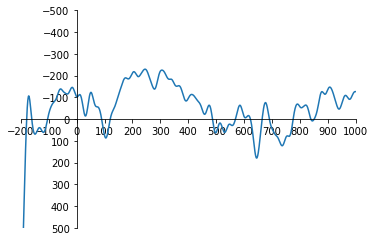

42


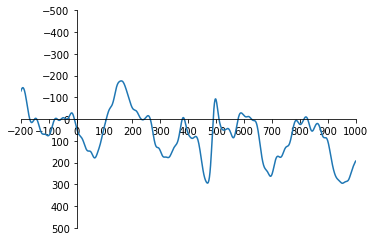

43


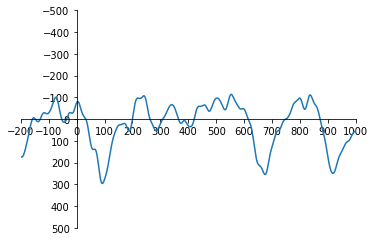

44


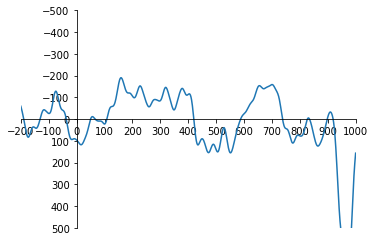

45


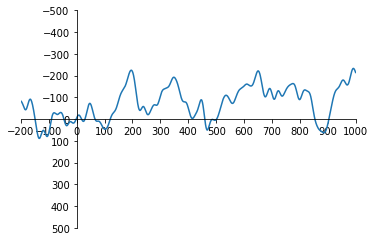

46


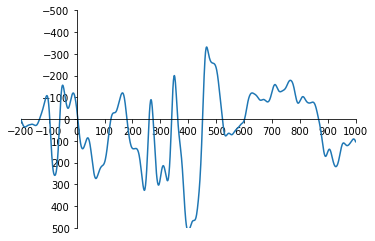

47


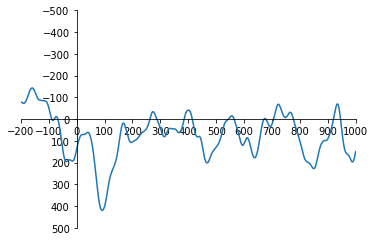

48


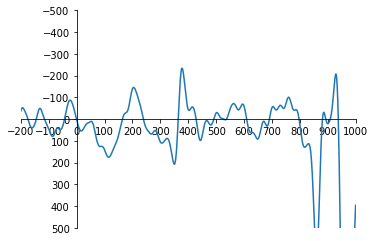

49


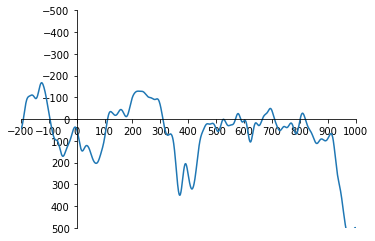

50


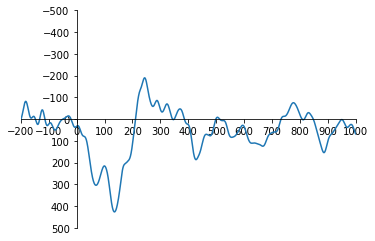

51


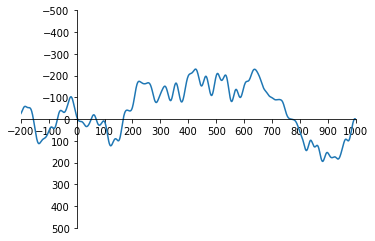

52


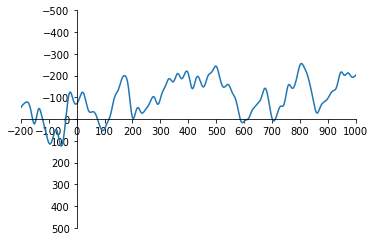

53


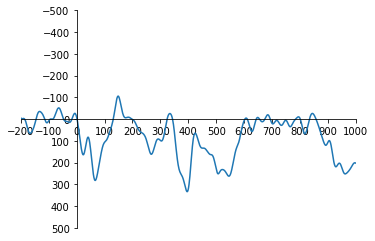

54


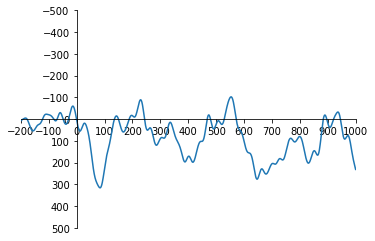

55


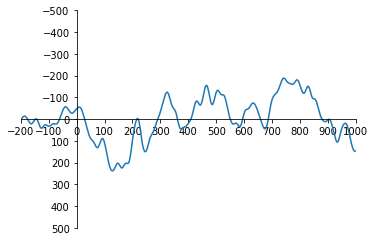

56


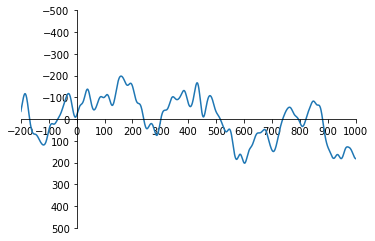

57


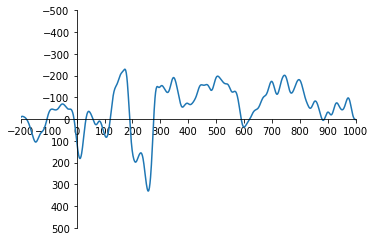

58


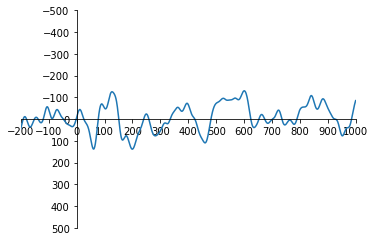

59


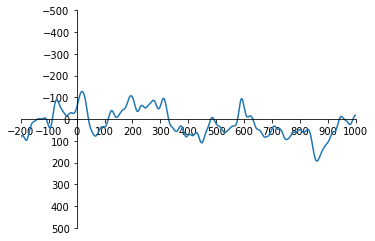

60


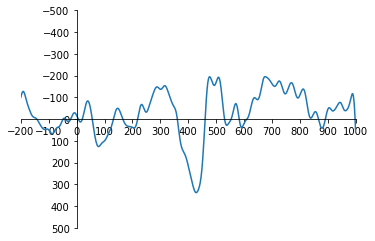

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
 
'''
 
実験A_2020.py
 
 
2020年度 広島大学総科行動系「心理学実験A」
視覚誘発電位データ分析用プログラム

・試行ごと表示　ON
・外れ値自動除外　OFF
・強制選択試行　含み
・キャリブレーション校正　含み
・ChebyshevⅠ型フィルター　ON
・Detrendフィルター　ON
 
 
Created by: Ruoheng "Qukoyk" Qu
            2020/06/11
 
'''
 
 
# import文
import numpy as np
import matplotlib.pyplot as plt
import time
import csv,os
from scipy import signal
# from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
 
 
# 定数宣言
waveMax = 500
waveMin = -500
drive.mount('/content/drive')
 
path = "/content/drive/My Drive" # 教示用
# path = "/content/drive/My Drive/実験" # 自機用
 
os.chdir(path)
 
# 変数宣言
fileName = 'taro0429Data.m00 のコピー' # 教示用
# fileName = 'taro0429Data.m00' # 自機用
position = 0
positionList = []
 
 
# トリガーのチャンネルを宣言
trg = 8
 
# 番号入力
chAnswer = input("分析したいチャンネルの番号を入力ください：\n")
print('\n'+"チャンネルデータ読み込み中……")
 
 
# 分析するチャンネルを読み込む
chList = []
chList0 = np.loadtxt(fileName, skiprows=2, usecols=int(chAnswer)-1)
print("読み込み完成")

print('\n'+"フィルターリング開始")

# Calibration
calCoef = 1.09049 # 校正係数
for i in chList0:
    chList.append(i/calCoef)
    pass

# バンドパス Chebyshev Ⅰ型　リップル1db（第一種チェビシェフフィルタ）
# フィルターパラメータ設定
highPass = 0.5 # Hz
lowPass = 50 # Hz
sFreq = 1000 # Hz
b, a = signal.cheby1(2,1,[highPass/sFreq, lowPass/sFreq],btype='bandpass')
chList = signal.filtfilt(b, a, chList)
# トレンド除去
chList = signal.detrend(chList)
print("フィルターリング済み")
 

# 関数 
# トリガー抽出関数
def triggerExtract(trigger):
    # 関数内変数を宣言
    counter = 0
    continuous = False
    position = 0
    tempPosition = 0
    triggerList = []
    tempList = np.loadtxt(fileName,skiprows=2, usecols=trigger-1)
    tempTriggerList = []
    # トリガー波形整形・二極化（測定の時トリガーチャンネルの感度の設定が怪しかったから）
    for i in tempList:
        if i > 5000000:
            tempTriggerList.append(1)
            pass
        else:
            tempTriggerList.append(0)
            pass
        pass
    # 抽出開始
    for i in tempTriggerList:
 
        if i > 0:
            continuous = False
            pass
            
        if i > 0 and continuous == False:
            if position - tempPosition > 30000: # 今回のトリガーは1200msではないため経験値を選出 (0430 -> 25000; 0501 -> 23000)
                counter = counter + 1
                triggerList.append(position)
                continuous = True
                tempPosition = position
                pass
            pass
        # 累進
        position = position + 1
        pass
 
    print('\n'+"全トリガーが",counter,"個検出された")
 
    # 強制選択試行トリガー外れ
    # 1234 1234 1234 1234 ... のような数列に
    # 1と2を外したいなら，第1位のことを2回外して，第3位のことを2回はずして
    # 第15位のことを2回外すことまで（計15ブロック）
    # for i in range(0,30,2):
        # del triggerList[i-1]
        # del triggerList[i-1]
        # pass
    # finalCounter = len(triggerList)
    # print("自由選択試行のトリガーが",finalCounter,"個検出された")
 
    return triggerList
 
# 外れ値検出関数
def triggerCheck(listName):
    # 局所変数設定
    position = 0
    badList = []
    tempList = []
    tempList1 = []
    trialList = []
    sessionList = []
 
    # 検出開始
    for i in listName:                     # i はトリガーの時点
 
        for j in range(i-200,i+1001):      # j はトリガーの時点前200ms~後1000msの時点
            k = chList[j]                  # k はj時点の脳波の値
            if k>waveMax or k<waveMin:
                tempList.append(position)  # k値は過大か過小ならこのトリガーを記録
                pass
            tempList1.append(k)            # tempList1は波形そのもの，つまり無修正なやつ
            pass
 
        # ベースライン（-200ms間を平均）
        baseLine = np.mean(tempList1[0:200])
        # トライアルリストのデータ（1トリガー前後1200ms間のデータ）とベースラインの差をセッションリストに導入
        for l in tempList1:
            trialList.append(l-baseLine)
            pass
        sessionList.append(trialList)
        # トライアルリストを初期化
        tempList1 = []
        trialList = []
        # ポジションのカウンターを累進
        position = position + 1
        pass
 
    # 重複要素を削除
    tempList = list(set(tempList))
    # ソーティング
    tempList.sort()
    # 辞書化
    m = {i:element for i, element in enumerate(sessionList)}
    # 外れ値除外
    # [m.pop(i) for i in tempList]
    # リストに戻す
    sessionList = list(m.values())
    # 「012345」から「123456」に変換
    for i in tempList:
        i = i + 1
        badList.append(i)
        pass
    # print('\n'+"外れるトリガーは",'\n',badList)
    # print("計",len(badList),"個")
    return sessionList
 
 
# メインプログラム
# トリガー抽出
print('\n'+"トリガー抽出開始……")
trgList = triggerExtract(trg)
# 外れ値検出 & データ行列化
trgArray = np.array(triggerCheck(trgList))
 
 
# 保存
np.savetxt(str(chAnswer)+'ch.csv',trgArray.T,delimiter=',')
 
# 加算平均
#trgMean = np.mean(trgArray,axis=0)
 
# グラフ作成
print('\n'+"これからトリガー前後の波形を表示")
position = 0
for i in trgArray:
    # 軸調整
    # デフォルトの書式なら、グラフの周囲に枠がある。
    # そして、グラフの中に横軸と縦軸はない。
    # なぜというと「枠」は軸そのものである。
    # ここは上と右の枠線を不可視化になってから
    # 左と下の枠をデータが「0」のところに移動する
    ax = plt.gca()
    ax.spines['right'].set_color('none')         
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))
    # 縦軸の反転
    ax.invert_yaxis()
    # 横軸の範囲設定
    x = np.arange(-200,1001)
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200,1001,100))
    plt.ylim(waveMax,waveMin)
    plt.yticks(np.arange(-500,501,100))
    # plt.xlabel("Time after stimulus (ms)")
    # plt.ylabel("Potential (μV)")
    plt.plot(x,i)
    position = position + 1
    print(position)
    plt.show()
    pass